Attempt 1

In [1]:
# !pip install --update pyldpc
import pyldpc
import numpy as np

In [2]:
n = 15  # Number of columns
d_v = 4 # Number of ones per column, must be lower than d_c (because H must have more rows than columns)
d_c = 5 # Number of ones per row, must divide n (because if H has m rows: m*d_c = n*d_v (compute number of ones in H))

H = pyldpc.RegularH(n,d_v,d_c)

print("Regular parity-check matrix H({},{},{}):\n\n".format(n,d_v,d_c),H)

Regular parity-check matrix H(15,4,5):

 [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 0 0 1 1 0 0 0 0 0 0 1 1 0 0]
 [0 1 0 0 0 1 1 1 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 1 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 1 0 0 0 1 1]
 [0 0 1 0 0 1 1 0 1 0 0 1 0 0 0]
 [0 0 0 1 1 0 0 1 0 0 1 0 1 0 0]
 [0 0 0 0 1 1 0 0 0 1 1 0 1 0 0]
 [0 1 1 0 0 0 1 1 0 0 0 1 0 0 0]
 [1 0 0 1 0 0 0 0 1 0 0 0 0 1 1]]


In [3]:
tG = pyldpc.CodingMatrix(H)
print("Transposed Coding Matrix tG that goes with H above is:\n\n",tG)
print("\n With G,H you can code messages of {} bits into codewords of {} bits because G's shape is {}\n".format(tG.shape[1], tG.shape[0],tG.T.shape))

Transposed Coding Matrix tG that goes with H above is:

 [[1 1 1 1 1 1]
 [0 1 1 1 0 0]
 [0 1 0 0 0 0]
 [0 0 1 1 1 1]
 [1 1 1 1 0 0]
 [0 1 0 1 1 1]
 [1 1 1 1 0 0]
 [1 1 1 0 0 0]
 [1 1 0 0 1 1]
 [1 0 0 0 0 0]
 [0 0 1 1 1 1]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]

 With G,H you can code messages of 6 bits into codewords of 15 bits because G's shape is (6, 15)



Attempt 2

In [4]:
# input
import numpy as np
import scipy
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix

H = np.array([[1, 1, 0, 1, 0, 0], 
              [0, 1, 1, 0, 1, 0],
              [1, 0, 0, 0, 1, 1],
              [0, 0, 1, 1, 0, 1]])

c = np.array([0, 0, 1, 0, 1, 1])
y = np.array([1, 0, 1, 0, 1, 1])
p = 0.2

In [5]:
log_p = np.log(p/(1-p))
r = log_p * (2 * (y == 1) - 1)
r

array([-1.38629436,  1.38629436, -1.38629436,  1.38629436, -1.38629436,
       -1.38629436])

In [6]:
def simple_sum_product_decording(H, r, maxiter=1, verbose=False):
#     Prepare
    n_check_nodes, n_bit_nodes = H.shape
    H_csr = csr_matrix(H)
    H_csc = H_csr.tocsc(copy=True)
    
    csr_ptr = H_csr.indptr
    csr_ind = H_csr.indices
    
    csc_ptr = H_csc.indptr
    csc_ind = H_csc.indices
    
    nnz = H_csr.nnz
    M_csc = np.empty(nnz, dtype=np.float64)
    E_csr = np.empty(nnz, dtype=np.float64)
    L = np.empty(n_bit_nodes, dtype=np.float64)
#     Initialize
    for i in range(n_bit_nodes):
#         M[csr_ptr[k]:csr_ptr[k+1]] = r[csr_ind[csr_ptr[k]:csr_ptr[k+1]]]
        M_csc[csc_ptr[i]:csc_ptr[i+1]] = r[i]
#         M_csc[csc_ptr[k]:csc_ptr[k+1]] = r[csc_ind[csc_ptr[k]:csc_ptr[k+1]]]
    if verbose:
        print("M:\n", csc_matrix((M_csc, csc_ind, csc_ptr)).toarray())
    history = []
    for ii in range(maxiter):
        M_csr = csc_matrix((M_csc, csc_ind, csc_ptr)).tocsr().data
        for j in range(n_check_nodes):
            j_beg = csr_ptr[j]
            j_end = csr_ptr[j+1]
            M_local = np.tanh(M_csr[j_beg:j_end] / 2)
            for e in range(j_end-j_beg):
                prod_local = M_local[:e].prod() * M_local[e+1:].prod()
                if np.allclose(np.abs(prod_local), 1, rtol=1e-15):
                    prod_local = 1 - 1e-15
                E_csr[j_beg+e] = np.log((1. + prod_local) / (1. - prod_local))
        if verbose:
            print("E:\n", csr_matrix((E_csr, csr_ind, csr_ptr)).toarray())
        E_csc = csr_matrix((E_csr, csr_ind, csr_ptr)).tocsc().data
#         Get message
        L = np.array(r)
        for i in range(n_bit_nodes):
            L[i] += E_csc[csc_ptr[i]:csc_ptr[i+1]].sum()
        z = 1 * (L <= 0)
        history.append(z)
#         Check message  
        if np.any(H.dot(z) % 2 != 0):
#             Update M
            for i in range(n_bit_nodes):
                i_beg = csc_ptr[i]              #column beg
                i_end = csc_ptr[i+1]            #column end
                E_local = E_csc[i_beg:i_end]
                for e, j in enumerate(csc_ind[i_beg:i_end]):
                    M_csc[i_beg+e] = E_local[:e].sum() + E_local[e+1:].sum() + r[i]
        else:
            break
    return z, history
        

In [7]:
r.shape

(6,)

In [8]:
z = simple_sum_product_decording(H, r)

## Experiments for MNIST

In [9]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [10]:
X = np.array(mnist.data, dtype=np.int16)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
side = int(np.sqrt(X.shape[1]))
shape = (side, side)

In [13]:
X[X > 0] = 1

### Encoding-Decoding Functions, which support two strategies: column by column and flatten coding.

In [14]:
def transmit_encode(message, tG, noise_rate):
    enc_mes = tG.dot(message)%2
    moduled = enc_mes.copy()
    moduled[moduled == 1] = -1
    moduled[moduled == 0] = 1
    noise = np.random.normal(0, np.sqrt(noise_rate), size=enc_mes.shape)
    channel = moduled + noise

    return enc_mes, channel
    
def decode(channel, noise_rate, strategy, maxiter):
    histories = []
    max_length = 0
    dec_mes = np.zeros_like(channel)
    
    from scipy.stats import norm
    
    if strategy == 'column':
        for index, row in enumerate(channel.T):
            p = norm.cdf(np.sqrt(1/noise_rate))
            log_p = np.log(p/(1-p))
            r = log_p * row

            dec_mes[:, index], history = simple_sum_product_decording(H, r, maxiter)
            histories.append(history)
            max_length = max(max_length, len(history))
    elif strategy == 'flat':
        r = 2 * channel / noise_rate
        dec_mes, histories = simple_sum_product_decording(H, r, maxiter=15)
        max_length = max(max_length, len(histories))
    else:
        print('Methods supports strategies: column and flat')
        raise TypeError
    return dec_mes, histories, max_length
    
def test_code(message, tG, noise_rate, strategy='column', file_save='decoding.jpg',
              maxiter=15,verbose=True):
    enc_mes, channel = transmit_encode(message, tG, noise_rate)
    dec_mes, histories, max_length = decode(channel, noise_rate, strategy, maxiter)

    rows = (max_length - 1) // 3 + 1
    if verbose:
        fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
        axes = axes.flatten()
        fig.suptitle('Decoding message, Noise={}'.format(noise_rate))
        """
        if strategy == 'column':
            axes[0].imshow(message, cmap='gray')
            axes[1].imshow(enc_mes, cmap='gray')
            axes[2].imshow(channel, cmap='gray')
        elif strategy == 'flat':
            axes[0].imshow(message.reshape(-1, 28), cmap='gray')
            axes[1].imshow(np.append(enc_mes, [0, 0, 0]).reshape(-1, 28), cmap='gray')
            axes[2].imshow(np.append(channel, [0, 0, 0]).reshape(-1, 28), cmap='gray')
        axes[0].set_title('Message')
        axes[1].set_title('Encoded Message')
        axes[2].set_title('Recieved Message')
        """
    wrong_bits = []

    if strategy == 'column':
        for index in range(max_length):
            image_to_show = []
            for j, history in enumerate(histories):
                try:
                    image_to_show.append(history[index])
                except IndexError:
                    image_to_show.append(history[-1])
            image_to_show = np.array(image_to_show).T
            wrong_bits_iter = np.sum(image_to_show != enc_mes)
            wrong_bits.append(wrong_bits_iter)

            if verbose:
                axes[index].imshow(image_to_show, cmap='gray')
                axes[index].set_title('Iteration {}, wrong bits: {}'.
                                        format(index+1, wrong_bits_iter))
    elif strategy == 'flat':
        for index, history in enumerate(histories):
            image_to_show = np.array(history)
            wrong_bits_iter = np.sum(image_to_show != enc_mes)
            wrong_bits.append(wrong_bits_iter)
    
            if verbose:
                axes[index].imshow(np.append(image_to_show, [0, 0, 0]).reshape(-1, 28), cmap='gray')
                axes[index].set_title('Iteration {}, wrong bits: {}'.
                                        format(index+1, wrong_bits_iter))
    if verbose:    
        fig.savefig(file_save)
    
    return wrong_bits

## Column by column coding strategy:

Take PCH, which constructs code with $1/4$ rate. 

In [15]:
H,tG = pyldpc.HtG(4,28, systematic=True)
print(tG.shape)

(104, 28)


### Encoding

In [16]:
message = X[20000].reshape(28, 28)
noise_rate = 0.5
enc_mes, channel = transmit_encode(message, tG, noise_rate)

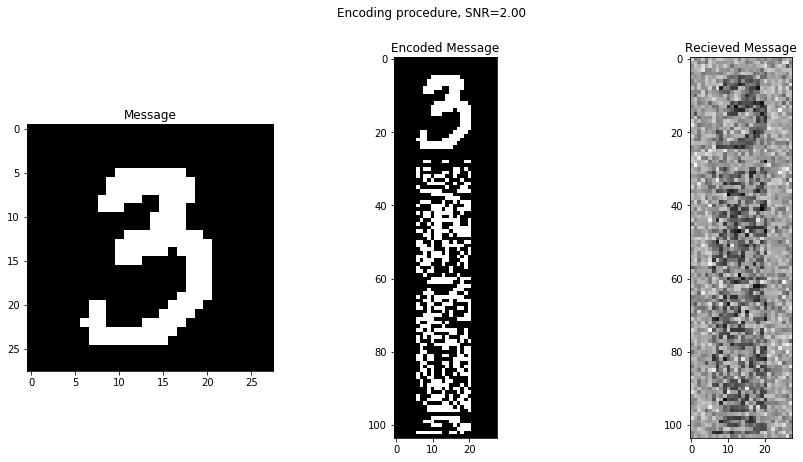

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes = axes.flatten()
        
fig.suptitle('Encoding procedure, SNR={:.2f}'.format(1/noise_rate))

axes[0].imshow(message, cmap='gray')
axes[1].imshow(enc_mes, cmap='gray')
axes[2].imshow(channel, cmap='gray')
axes[0].set_title('Message')
axes[1].set_title('Encoded Message')
axes[2].set_title('Recieved Message')

fig.savefig('screen.png')

### Decoding

[286, 205, 155, 129, 101, 86, 75, 67, 60, 55, 50, 42, 63, 77, 84]

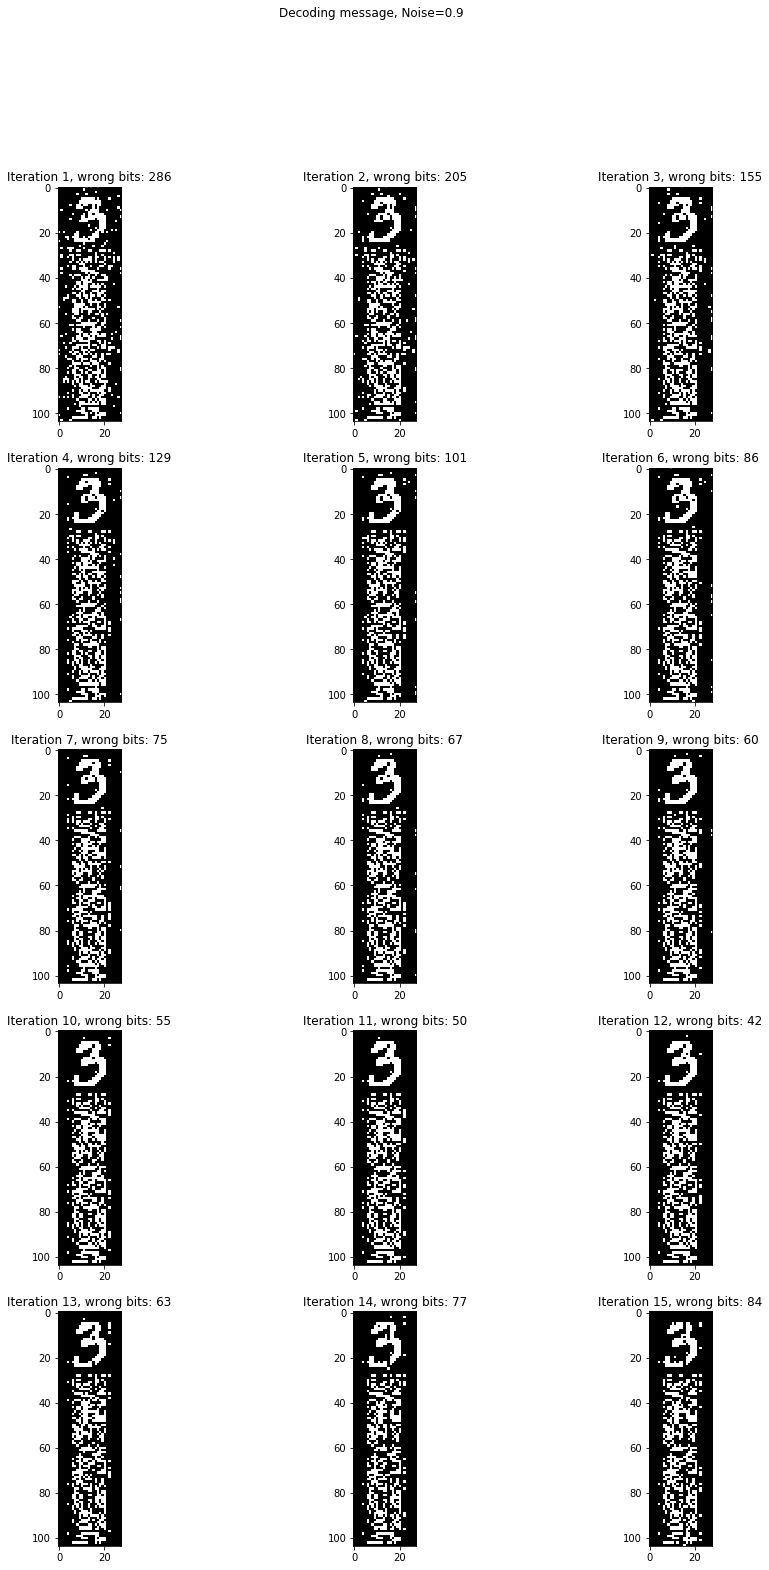

In [18]:
test_code(message, tG, noise_rate=0.9, maxiter=15, verbose=True)

Function, which makes animation of the deconding process.

In [19]:
import matplotlib.animation as animation
from IPython.display import HTML

def make_video(noise_rate, filename):
    enc_mes, channel = transmit_encode(message, tG, noise_rate=noise_rate)
    dec_mes, histories, max_length = decode(channel, noise_rate=noise_rate, strategy='column', maxiter=15)
    bits = enc_mes.shape[0] * enc_mes.shape[1]

    fig, axes = plt.subplots(1, 4, figsize=(15, 7))
    axes = axes.flatten()

    fig.suptitle('Decoding procedure, SNR={:.2f}'.format(1/noise_rate))

    axes[0].imshow(message, cmap='gray')
    axes[1].imshow(enc_mes, cmap='gray')
    axes[2].imshow(channel, cmap='gray')
    axes[0].set_title('Message')
    axes[1].set_title('Encoded Message')
    axes[2].set_title('Recieved Message')
    wrong_bits = []
    ims = []
    ttl = axes[3].text(0.5, 1.01, 'Recieved Message', horizontalalignment='center', 
                   verticalalignment='bottom', transform=axes[3].transAxes)
    im = axes[3].imshow(channel, cmap='gray', animated=True)
    ims.append([im, ttl])
    for index in range(max_length):
        image_to_show = []
        for j, history in enumerate(histories):
            try:
                image_to_show.append(history[index])
            except IndexError:
                image_to_show.append(history[-1])
        image_to_show = np.array(image_to_show).T
        wrong_bits_iter = np.sum(image_to_show != enc_mes)
        title = 'Iteration {}, wrong bits: {}/{}'.format(index+1, wrong_bits_iter, bits)
        ttl = axes[3].text(0.5, 1.01, title, horizontalalignment='center', 
                       verticalalignment='bottom', transform=axes[3].transAxes)
        im = axes[3].imshow(image_to_show, cmap='gray', animated=True)
        ims.append([im, ttl])

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                    repeat_delay=1000)
    ani.save(filename)

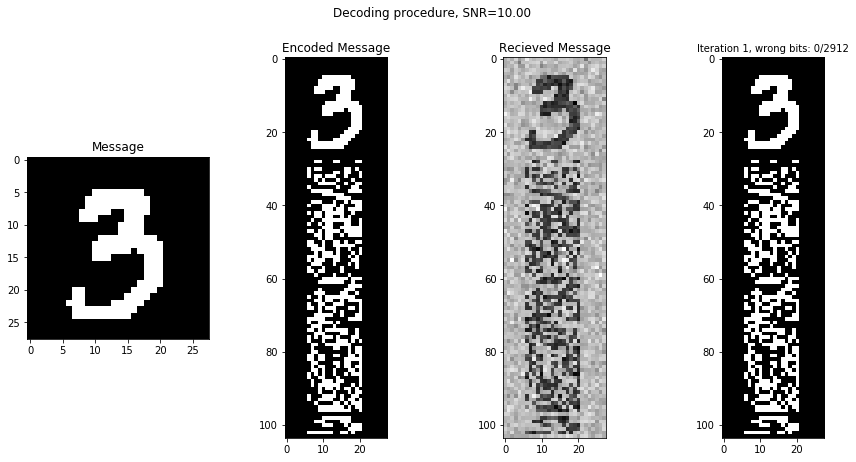

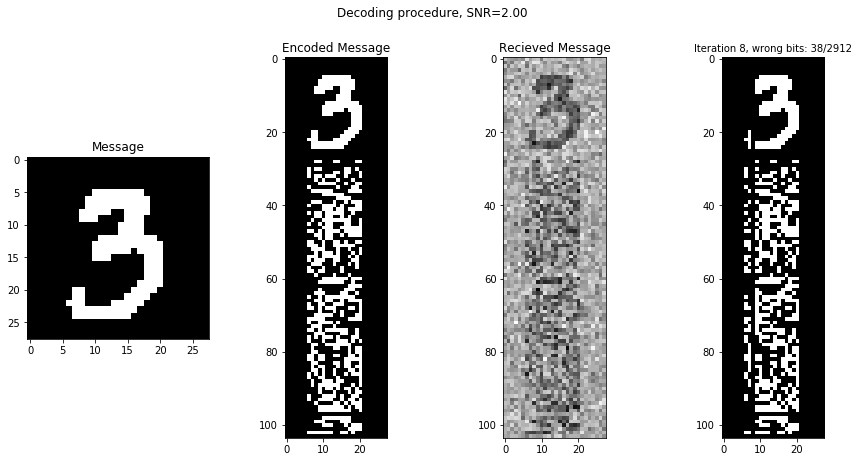

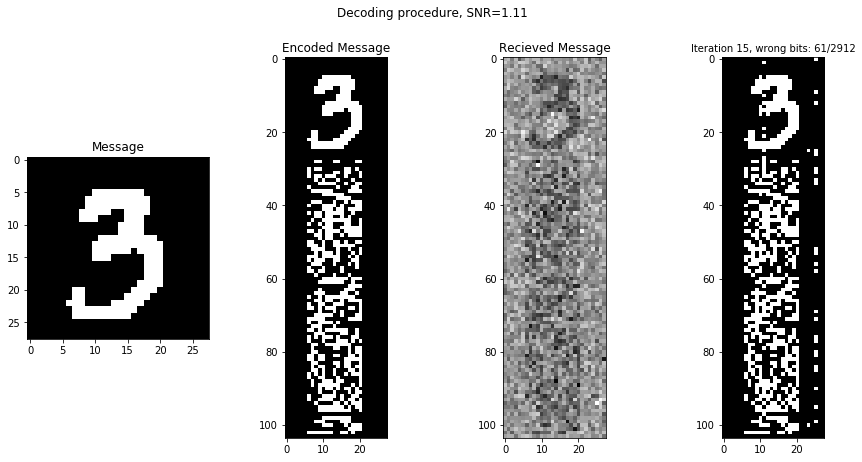

In [20]:
for noise_rate, filename in zip([0.1, 0.5, 0.9], 
                                ['mov01.mp4', 'mov05.mp4', 'mov09.mp4']):
    make_video(noise_rate, filename)

Compare codes with different rates:

In [21]:
from tqdm import tqdm

noise_rates = np.arange(0.05, 1.05, 0.05)

H,tG = pyldpc.HtG(4,28, systematic=True)
pakets = []
for i in tqdm(range(20)):
    wrong_bits = []
    for noise_rate in noise_rates:
        wrong_bits.append(test_code(message, tG, noise_rate, verbose=False)[-1])
    pakets.append(wrong_bits)

H,tG = pyldpc.HtG(3,28, systematic=True)
pakets2 = []
for i in tqdm(range(20)):
    wrong_bits = []
    for noise_rate in noise_rates:
        wrong_bits.append(test_code(message, tG, noise_rate, verbose=False)[-1])
    pakets2.append(wrong_bits)

100%|██████████| 20/20 [04:44<00:00, 14.01s/it]


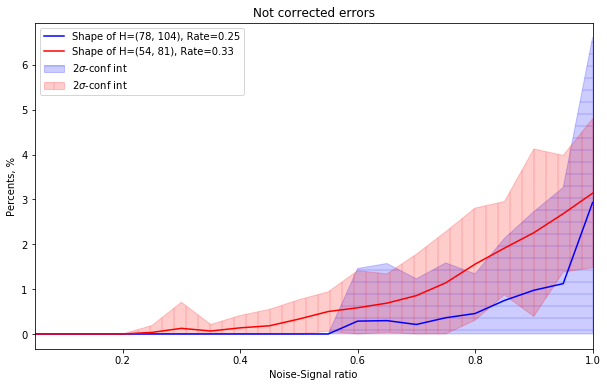

In [22]:
fig, ax = plt.subplots(1, figsize=(10, 6))

line = np.array(pakets).mean(axis=0) / (tG.shape[0] * tG.shape[1]) * 100
line2 = np.array(pakets2).mean(axis=0) / (tG.shape[0] * tG.shape[1]) * 100
epsilon = np.array(pakets).std(axis=0) / (tG.shape[0] * tG.shape[1]) * 100
epsilon2 = np.array(pakets2).std(axis=0) / (tG.shape[0] * tG.shape[1]) * 100
ax.plot(noise_rates, line, c='b', label='Shape of H={}, Rate={:.2f}'.format((78, 104), 1/4))
ax.plot(noise_rates, line2, c='r', label='Shape of H={}, Rate={:.2f}'.format((54, 81), 1/3))
ax.fill_between(noise_rates, np.maximum(line - 2 * epsilon, 0), line+2*epsilon, alpha=0.2, color='b', hatch = '-',label='$2\sigma$-conf int')
ax.fill_between(noise_rates, np.maximum(line2 - 2 * epsilon2, 0), line2+2*epsilon2, alpha=0.2, color='r', hatch = '|',label='$2\sigma$-conf int')
ax.set_xlim([0.05, 1])
ax.set_title('Not corrected errors')
ax.set_xlabel('Noise-Signal ratio')
ax.set_ylabel('Percents, %')
ax.legend(loc=2)

fig.savefig('error.jpg')

### Try to code pictures as one vector:

In [23]:
H,tG = pyldpc.HtG(3,28**2)
print(tG.shape)

(2349, 784)


[63, 19, 6, 6, 2, 8, 18, 52, 108, 175, 260, 388, 501, 515, 393]

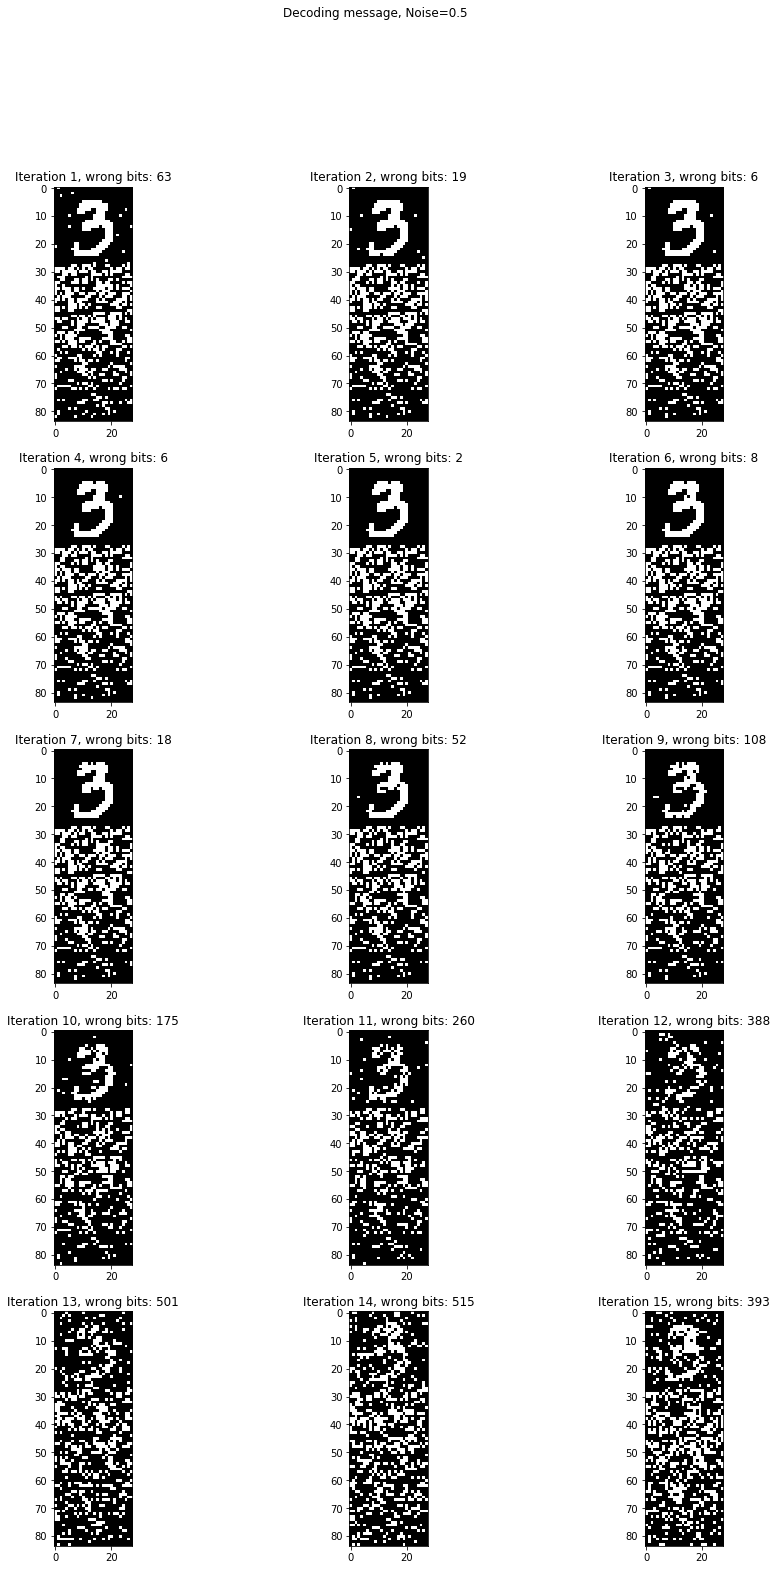

In [24]:
test_code(message.flatten(), tG, noise_rate=0.5, strategy='flat', verbose=True)